In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from typing import Union
from math import ceil
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.legacy import SGD, Adam
import tensorflow_hub as hub

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rudrashah/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/rudrashah/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [67]:
labels_array = ['Negative','positive']

In [68]:
f = 'movie.csv'
df = pd.read_csv(f)
df

,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1
...,...,...
39995,"""Western Union"" is something of a forgotten cl...",1
39996,This movie is an incredible piece of work. It ...,1
39997,My wife and I watched this movie because we pl...,0
39998,"When I first watched Flatliners, I was amazed....",1


In [69]:
df.groupby('label').count()

,text
label,
0,20019
1,19981


In [70]:
X,y = df['text'], df['label']

In [71]:
def remove_tags(input):
    result = re.sub('<.*?>','',input)          #remove HTML tags
    result = re.sub('https?://\S+|www\.\S+','',result)   #remove URLs
    result = re.sub(r'\W', ' ',result)    #remove non-alphanumeric characters 
    result = result.lower() #Making it to lower
    result = result.replace('rt', '')
    return result

X = X.apply(lambda x: remove_tags(x))

In [72]:
def remove_stopwords(input):
    stopwords_set = set(stopwords.words('english'))
    words = input.split()
    result = [word for word in words if word.strip().lower() not in stopwords_set]
    return " ".join(result)

for i in range(len(X)):
    X.iloc[i] =  remove_stopwords(X.iloc[i])

In [73]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    st = ""
    for w in w_tokenizer.tokenize(text):
        st = st + lemmatizer.lemmatize(w) + " "
    return st

for i in range(len(X)):
    X.iloc[i] =  lemmatize_text(X.iloc[i])

In [74]:
X.head()

0    grew b 1965 watching loving thunderbird mate s...
1    put movie dvd player sat coke chip expectation...
2    people know paicular time past like feel need ...
3    even though great interest biblical movie bore...
4    im die hard dad army fan nothing ever change g...
Name: text, dtype: object

In [75]:
label_encoder = LabelEncoder()
y_label = label_encoder.fit_transform(y)
y_label

array([0, 0, 0, ..., 0, 1, 1])

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y_label, test_size=0.2)

In [77]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((32000,), (8000,), (32000,), (8000,))

In [78]:
vocab_size = 6000
embedding_dim = 100
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = len(X_train)
print(training_size)

32000


In [79]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index
dict(list(word_index.items())[0:10])

{'<OOV>': 1,
 'movie': 2,
 'film': 3,
 'one': 4,
 'like': 5,
 'time': 6,
 'good': 7,
 'character': 8,
 'story': 9,
 'even': 10}

In [80]:
train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
train_padded.shape

(32000, 100)

In [81]:
model = Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add(tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(embedding_dim)))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [82]:
adam = Adam(lr=0.0001)
model.compile(loss='binary_crossentropy',optimizer=adam,metrics=['accuracy'])

/opt/homebrew/lib/python3.11/site-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [83]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 100, 100)          600000    
                                                                 
 bidirectional_6 (Bidirecti  (None, 200)               160800    
 onal)                                                           
                                                                 
 dense_6 (Dense)             (None, 16)                3216      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 764033 (2.91 MB)
Trainable params: 764033 (2.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [84]:
model.fit(train_padded, y_train, epochs=10,validation_split=0.2)

Epoch 1/10


800/800 [==============================] - 42s 51ms/step - loss: 0.5159 - accuracy: 0.7298 - val_loss: 0.3632 - val_accuracy: 0.8444
Epoch 2/10
800/800 [==============================] - 40s 50ms/step - loss: 0.3030 - accuracy: 0.8756 - val_loss: 0.3437 - val_accuracy: 0.8545
Epoch 3/10
800/800 [==============================] - 42s 52ms/step - loss: 0.2542 - accuracy: 0.8985 - val_loss: 0.3309 - val_accuracy: 0.8594
Epoch 4/10
800/800 [==============================] - 44s 55ms/step - loss: 0.2280 - accuracy: 0.9116 - val_loss: 0.3434 - val_accuracy: 0.8545
Epoch 5/10
800/800 [==============================] - 42s 52ms/step - loss: 0.2116 - accuracy: 0.9192 - val_loss: 0.3459 - val_accuracy: 0.8561
Epoch 6/10
800/800 [==============================] - 41s 51ms/step - loss: 0.1980 - accuracy: 0.9252 - val_loss: 0.3794 - val_accuracy: 0.8500
Epoch 7/10
800/800 [==============================] - 42s 52ms/step - loss: 0.1838 - accuracy: 0.9337 - val_loss: 0.4458 - val_accuracy: 0.8441
Epo

In [85]:
model.evaluate(train_padded, y_train)

   1/1000 [..............................] - ETA: 30s - loss: 0.0799 - accuracy: 0.9688

1000/1000 [==============================] - 16s 16ms/step - loss: 0.1954 - accuracy: 0.9396


[0.1953745186328888, 0.9395624995231628]

In [86]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = tf.keras.preprocessing.sequence.pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [87]:
model.evaluate(test_padded, y_test)

250/250 [==============================] - 4s 16ms/step - loss: 0.4967 - accuracy: 0.8382


[0.49666929244995117, 0.8382499814033508]

In [92]:
sent = ['you are very good.']
sample_seq = tokenizer.texts_to_sequences(sent)
sample_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
pred = model.predict(sample_padded)
print(pred[0][0])
pred = pred.round()
print(labels_array[int(pred)])

1/1 [==============================] - 0s 19ms/step
0.75111496
positive


In [89]:
ans = []
samp_range = 400
X_test = X_test[:samp_range] 
for i in range(len(X_test)):
    sent = [X_test.iloc[i]]
    sample_seq = tokenizer.texts_to_sequences(sent)
    sample_padded = tf.keras.preprocessing.sequence.pad_sequences(sample_seq, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    pred = model.predict(sample_padded)
    ans.append(pred[0][0])
print(len(ans))

1/1 [==============================] - 0s 17ms/step
400


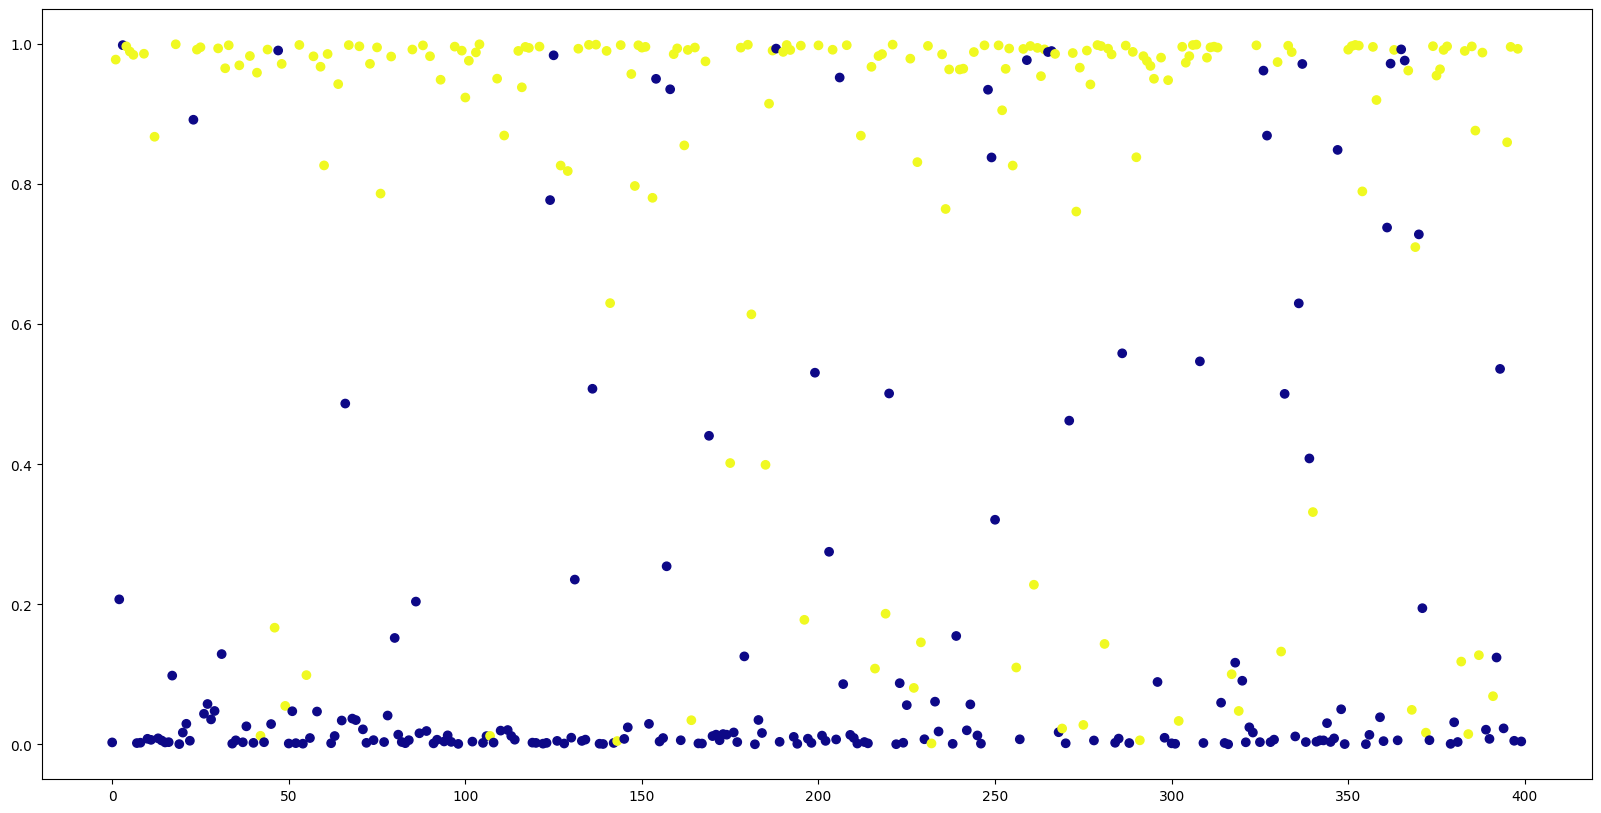

In [90]:
plt.figure(figsize=(20,10))
plt.scatter(range(samp_range), ans, c=y_test[:samp_range], cmap='plasma')